In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/Capstone Project/GAN-Capstone/")

In [3]:
!ls
!pip install netcdf4

000_norm.nc	      data_all_features.pkl    results_akshata.pkl
000_train.nc	      data.pkl		       results_diff_optim_hrishi.pkl
000_train_shuffle.nc  results_aashna.pkl       results.pkl
000_valid.nc	      results-aashna.pkl
checkpoints	      results_akshata_new.pkl
     |████████████████████████████████| 4.1MB 4.7MB/s 
     |████████████████████████████████| 317kB 41.5MB/s 


In [0]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as s
import pickle
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [0]:
d_vars = pickle.load(open('data.pkl','rb'))

In [11]:
d_vars.shape

(35458560, 5)

In [13]:
d_vars

,lat,lon,var_names,vars,time
0,-90.0,0.0,PRECT,6.826498e-10,0
1,-90.0,0.0,QBP,4.840826e-05,0
2,-90.0,0.0,TBP,2.068339e+02,0
3,-90.0,2.5,PRECT,6.949842e-10,0
4,-90.0,2.5,QBP,4.840826e-05,0
...,...,...,...,...,...
41467,90.0,355.0,QBP,1.304923e-03,862
41468,90.0,355.0,TBP,2.441204e+02,862
41469,90.0,357.5,PRECT,6.500282e-09,862
41470,90.0,357.5,QBP,1.304923e-03,862


In [0]:
d_vars = d_vars.pivot_table('vars',['lat','lon','time'],'var_names').reset_index()
d_non_zero = d_vars[d_vars.PRECT>0]

In [0]:
plt.hist(s.boxcox(d_non_zero.PRECT,0.1),density=True,bins=20)
plt.xlabel('BoxCox Transform of PRECT')
plt.ylabel('Density')

In [15]:
d_non_zero['PRECT_NEW'] = s.boxcox(d_non_zero.PRECT, 0.1)
d_non_zero['QBP_NEW'] = d_non_zero.QBP**(1/4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
d_non_zero = (d_non_zero).astype({'QBP_NEW': 'float32'})
d_non_zero.dtypes

var_names
lat          float64
lon          float64
time           int64
PRECT        float32
QBP          float32
TBP          float32
PRECT_NEW    float32
QBP_NEW      float32
dtype: object

In [17]:
data=np.array(d_non_zero[['PRECT_NEW','QBP_NEW','TBP']])
data.shape

(8121856, 3)

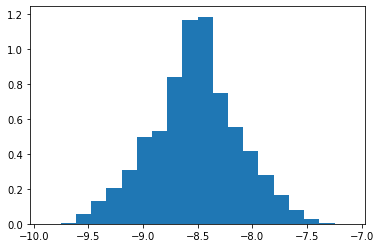

In [18]:
plt.hist(d_non_zero.PRECT_NEW.values, density=True, bins=20)
plt.show()

In [0]:
d_non_zero.describe()

var_names,lat,lon,time,PRECT,QBP,TBP,PRECT_NEW,QBP_NEW
count,8.121856e+06,8.121856e+06,8.121856e+06,8.121856e+06,8.121856e+06,8.121856e+06,8.121856e+06,8.121856e+06
mean,-3.104719e+00,1.830262e+02,4.307007e+02,3.934345e-08,2.068189e-03,2.450582e+02,-8.212408e+00,1.943668e-01
std,5.648257e+01,1.007385e+02,2.482653e+02,1.138142e-07,1.654640e-03,1.395648e+01,5.035992e-01,5.522918e-02
min,-9.000000e+01,0.000000e+00,0.000000e+00,1.999409e-20,1.246195e-05,2.024226e+02,-9.892826e+00,5.941506e-02
25%,-5.400000e+01,1.000000e+02,2.170000e+02,8.233272e-10,7.904472e-04,2.344949e+02,-8.765312e+00,1.676750e-01
50%,-6.631579e+00,1.850000e+02,4.300000e+02,5.232335e-09,1.547502e-03,2.447079e+02,-8.514510e+00,1.983388e-01
75%,5.021053e+01,2.675000e+02,6.440000e+02,2.284181e-08,3.311314e-03,2.467622e+02,-8.278635e+00,2.398833e-01
max,9.000000e+01,3.575000e+02,8.620000e+02,4.066384e-06,7.329976e-03,2.540453e+02,-7.109847e+00,2.926009e-01


In [19]:
data=np.array(d_non_zero[['PRECT_NEW','QBP_NEW','TBP']])
data

array([[-8.7882309e+00,  8.3412252e-02,  2.0683391e+02],
       [-8.7889423e+00,  8.3439901e-02,  2.0683858e+02],
       [-8.7895212e+00,  8.3467156e-02,  2.0684254e+02],
       ...,
       [-8.4469862e+00,  1.9015445e-01,  2.4412932e+02],
       [-8.4513035e+00,  1.9010726e-01,  2.4412459e+02],
       [-8.4819250e+00,  1.9006240e-01,  2.4412044e+02]], dtype=float32)

Data Loader

In [20]:
data_loader = torch.utils.data.DataLoader(data, batch_size=1024, shuffle=False)
# Num batches
num_batches = len(data_loader)
num_batches

7932

In [0]:
class DiscriminatorNet(torch.nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 3
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
  
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x.cuda())
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

In [0]:
class GeneratorNet(torch.nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 3
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 256),
            nn.ReLU(),
  
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # self.last_in1 = nn.Linear(1024, 1)
        # self.last_in2 = nn.Linear(1024, 1)
        self.last_in3 = nn.Linear(1024, 1)
        self.last_in4 = nn.Linear(1024, 2)
        self.act4 = nn.ReLU()


    def forward(self, x):
        x = self.hidden0(x.cuda())
        x = self.hidden1(x)
        x = self.hidden2(x)
        # x1 = self.last_in1(x)
        # x1 = mapping_to_target_range(x1, -90.0, 90.0)

        # x2 = self.last_in2(x)
        # x2 = mapping_to_target_range(x2, -180.0, 180.0)
       
        x3 = self.last_in3(x)

        x4 = self.last_in4(x)
        # x4 = self.act4(x4)

        x = torch.cat([x3,x4],1)
        # x = torch.cat([x1,x2,x3,x4],1)
        # x = self.out(x)
        return x
generator = GeneratorNet()

In [0]:
def mapping_to_target_range(x, target_min, target_max) :
  x02 = torch.tanh(x) + 1 # x in range(0,2)
  scale = ( target_max-target_min )/2.
  return  x02 * scale + target_min

In [0]:
use_cuda=True
if use_cuda and torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [0]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    n.cuda()
    return n

We experimented with two different kinds of optimizers to see if it led to better results for the generator.

In [0]:
d_optimizer = optim.SGD(discriminator.parameters(), lr=0.0004, momentum=0.8)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001)

In [0]:
loss = nn.BCELoss()

In [28]:
torch.cuda.is_available()

True

In [0]:
def train_discriminator(optimizer, data, labels):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction = discriminator(data)
    prediction.cuda()
    
    labels=labels.cuda()

    error_total = loss(prediction, labels)
    error_total.backward()

    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_total, prediction

In [0]:
def train_generator(optimizer, fake_data, labels):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()

    #y_gen = np.ones(N)

    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    prediction.cuda()

    labels=labels.cuda()

    # Calculate error and backpropagate
    error = loss(prediction, labels)

    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [0]:
drive_root = "/content/drive/My Drive/Capstone Project/GAN-Capstone/"
checkpoint_dir = os.path.join(drive_root, "checkpoints")
# your name here
checkpoint_dir = os.path.join(checkpoint_dir, "hrishi")

In [32]:
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)

Checkpoints directory is /content/drive/My Drive/Capstone Project/GAN-Capstone/checkpoints/hrishi
Checkpoints folder already exists


In [0]:
#!rm -r /content/drive/My\ Drive/Capstone\ Project/GAN-Capstone/checkpoints/hrishi

In [33]:
chkpts = os.listdir(checkpoint_dir)
if chkpts:
  latest = chkpts[0]
  print(latest)
  saved = torch.load(checkpoint_dir+'/'+latest)
  generator.load_state_dict(saved['gen_state_dict'])
  discriminator.load_state_dict(saved['disc_state_dict'])
  g_optimizer.load_state_dict(saved['gen_optimizer_state_dict'])
  d_optimizer.load_state_dict(saved['disc_optimizer_state_dict'])
  current_epoch = saved['epoch']+1
  g_error = saved['gen_loss']
  d_error = saved['disc_loss']
else:
  current_epoch = 0

current_epoch

checkpoint.pt


98

In [0]:
dtype = torch.cuda.FloatTensor

In [36]:

num_epochs = 100

for epoch in range(current_epoch,num_epochs):
  results = pd.DataFrame(columns=['Prect','QBP','TBP'])
  for n_batch,real_batch in enumerate(data_loader):
    N = real_batch.size(0)
    
    # 1. Train Discriminator
    real_data = real_batch
    real_data.cuda()
    
    # Generate fake data and detach 
    # (so gradients are not calculated for generator)
    noi=noise(N)
    noi.cuda()

    fake_data = generator(noi).detach()
    fake_data.cuda()

    #Generate real data and label it as 1, Train on real data
    X1= np.array(real_data)
    X1_torch = Variable(torch.from_numpy(X1).float())
    X1_torch.cuda()

    y_dis_1=np.ones(N)
    y_torch_1 = Variable(torch.from_numpy(y_dis_1).float())
    y_torch_1.cuda()
    
    d_error_1, d_pred_1 = train_discriminator(d_optimizer, X1_torch ,y_torch_1)
    
    # Label Fake data as 0, train on fake data
    fake_data_temp=fake_data.cpu()
    X2= np.array(fake_data_temp)
    X2_torch = Variable(torch.from_numpy(X2).float())
    X2_torch.cuda()

    y_dis_2=np.zeros(N)
    y_dis_2[:N]=0
    y_torch_2 = Variable(torch.from_numpy(y_dis_2).float())
    y_torch_2.cuda()

    d_error_2, d_pred_2 = train_discriminator(d_optimizer, X2_torch ,y_torch_2)

    #Add real and fake errors
    d_error=d_error_1+d_error_2
    

    # 2. Train Generator
    fake_data = generator(noise(N))
  
    fake_data.cuda()
    
    y_gen = np.ones(N)
    y_torch_gen = Variable(torch.from_numpy(y_gen).float())
    y_torch_gen.cuda()

    g_error = train_generator(g_optimizer, fake_data, y_torch_gen)
    

    if (n_batch) % 100 == 0: 
      #Print results for every 100 epochs
      print('Epoch: {},\nDiscriminator Loss: {},\nGenerator Loss: {},\nGenerated Data: {}'.format(epoch+1,
                                                                                               d_error.cpu().detach().numpy(),
                                                                                               g_error.cpu().detach().numpy(),
                                                                                               fake_data[0].cpu().detach().numpy()))


    results = results.append(pd.DataFrame(fake_data.tolist(), columns=results.columns))

  checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint.pt')

  torch.save({'epoch': epoch,
              'gen_state_dict': generator.state_dict(),
              'disc_state_dict': discriminator.state_dict(),
              'gen_optimizer_state_dict': g_optimizer.state_dict(),
              'disc_optimizer_state_dict': d_optimizer.state_dict(),
              'gen_loss': g_error,
              'disc_loss': d_error,},
             checkpoint_path)
  
  pickle.dump(results, open('results_diff_optim_hrishi.pkl', 'wb'))
  print('Saved model at ', checkpoint_path)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 99,
Discriminator Loss: 1.554532527923584,
Generator Loss: 0.6800926327705383,
Generated Data: [ -7.6588445   0.315098  224.13672  ]
Epoch: 99,
Discriminator Loss: 1.3775055408477783,
Generator Loss: 0.7386147379875183,
Generated Data: [ -6.999325     0.28966463 187.53569   ]
Epoch: 99,
Discriminator Loss: 1.3679182529449463,
Generator Loss: 0.6643720865249634,
Generated Data: [-7.3572702e+00  1.6724841e-01  1.8196181e+02]


KeyboardInterrupt: ignored

In [0]:
results = pickle.load(open('results_diff_optim_hrishi.pkl', 'rb'))

Text(0, 0.5, 'Density')

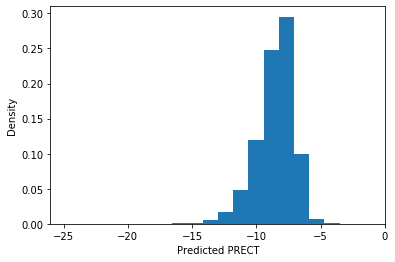

In [0]:
plt.hist(results['Prect'], density=True, bins=20)
plt.xlabel('Predicted PRECT')
plt.ylabel('Density')

In [0]:
len(results.Prect.unique())

3854153

In [0]:
len(results.QBP.unique())

7334953

In [0]:
results.describe()

,Prect,QBP,TBP
count,8.121856e+06,8.121856e+06,8.121856e+06
mean,-8.520423e+00,1.818184e-01,2.384664e+02
std,9.379509e-01,2.494211e-01,3.022994e+01
min,-1.688303e+01,-5.256616e+00,5.931293e+01
25%,-9.147478e+00,6.704626e-02,2.178647e+02
50%,-8.497784e+00,1.993461e-01,2.392970e+02
75%,-7.872310e+00,3.229556e-01,2.595291e+02
max,-2.629944e+00,1.735109e+00,4.774305e+02


In [0]:
q = results.QBP**4 #s.inv_boxcox(results.QBP,0.4)
p = s.inv_boxcox(results.Prect, 0.1)

(array([1.15029406e-04, 4.82946535e-03, 5.70276491e-02, 1.29337294e-01,
        2.04175425e-01, 3.06355716e-01, 4.93892911e-01, 5.31465939e-01,
        8.38895298e-01, 1.16390380e+00, 1.18346750e+00, 7.49755472e-01,
        5.55807931e-01, 4.13698300e-01, 2.79700120e-01, 1.64426572e-01,
        8.11665183e-02, 2.55090106e-02, 2.91465818e-03, 9.82174156e-05]),
 array([-9.892826 , -9.753677 , -9.614529 , -9.475379 , -9.33623  ,
        -9.197082 , -9.057932 , -8.918783 , -8.779634 , -8.640486 ,
        -8.501337 , -8.362187 , -8.223039 , -8.08389  , -7.944741 ,
        -7.8055916, -7.666443 , -7.527294 , -7.388145 , -7.248996 ,
        -7.109847 ], dtype=float32),
 <a list of 20 Patch objects>)

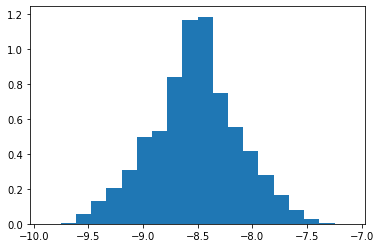

In [0]:
plt.hist((d_non_zero.PRECT_NEW), density=True, bins=20)

In [0]:
ans = pd.concat([p.reset_index(drop=True),q.reset_index(drop=True)], axis=1)
ans

,Prect,QBP
0,1.465472e-06,0.000856
1,3.214526e-15,0.001864
2,4.788991e-08,0.000500
3,3.127903e-09,0.002209
4,2.029332e-09,0.002363
...,...,...
8121851,7.230432e-17,0.000810
8121852,2.066362e-06,0.002317
8121853,9.306246e-09,0.009734
8121854,5.063294e-12,0.007125


Text(0, 0.5, 'PRECT')

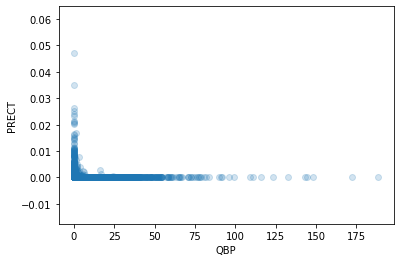

In [0]:
plt.scatter(ans.QBP, ans.Prect, alpha=0.2)
plt.xlabel('QBP')
plt.ylabel('PRECT')

Text(0, 0.5, 'PRECT')

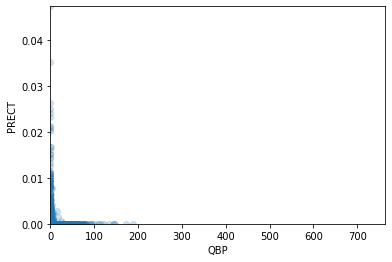

In [0]:
plt.scatter(ans.QBP, ans.Prect, alpha=0.2)
plt.xlim(ans.QBP.min(), ans.QBP.max())
plt.ylim(ans.Prect.min(), ans.Prect.max())
plt.xlabel('QBP')
plt.ylabel('PRECT')

(1.999409e-20, 4.066384e-06)

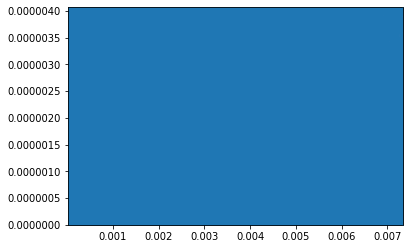

In [0]:
plt.scatter(ans.QBP, ans.Prect, alpha=0.2)
plt.xlim(1.246195e-05, 7.329976e-03)
plt.ylim(1.999409e-20, 4.066384e-06)

Text(0, 0.5, 'PRECT')

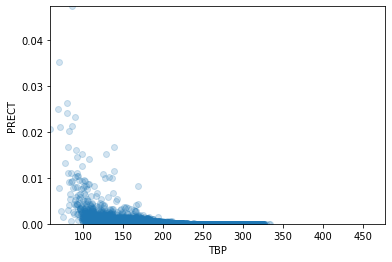

In [0]:
plt.scatter(results.TBP, ans.Prect, alpha=0.2)
plt.xlim(results.TBP.min(), results.TBP.max())
plt.ylim(ans.Prect.min(), ans.Prect.max())
plt.xlabel('TBP')
plt.ylabel('PRECT')

Text(0, 0.5, 'Density')

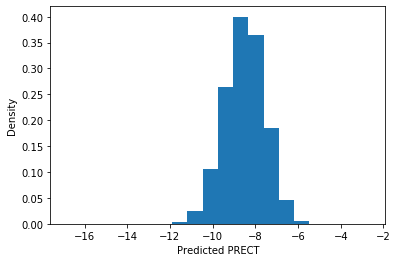

In [0]:
plt.hist(results['Prect'], density=True, bins=20)
plt.xlabel('Predicted PRECT')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

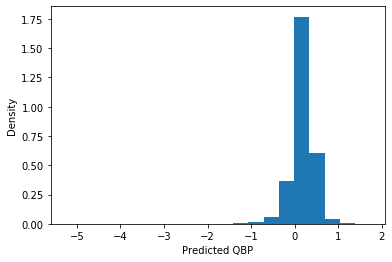

In [0]:
plt.hist(results.QBP, density=True, bins=20)
plt.xlabel('Predicted QBP')
plt.ylabel('Density')

(array([0.1859831 , 0.22392221, 0.26433456, 0.30535676, 0.34579268,
        0.38372564, 0.41839715, 0.44739958, 0.46886441, 0.48246161,
        0.48850993, 0.48124293, 0.46599144, 0.4417387 , 0.40624106,
        0.36613313, 0.32185973, 0.27498498, 0.22831624, 0.18529023]),
 array([-9.89282608, -9.75367718, -9.61452827, -9.47537937, -9.33623047,
        -9.19708157, -9.05793266, -8.91878376, -8.77963486, -8.64048595,
        -8.50133705, -8.36218815, -8.22303925, -8.08389034, -7.94474144,
        -7.80559254, -7.66644363, -7.52729473, -7.38814583, -7.24899693,
        -7.10984802]),
 <a list of 20 Patch objects>)

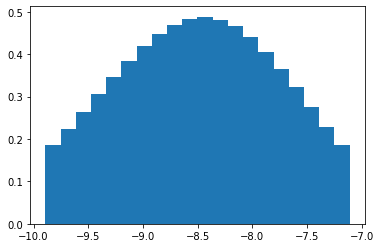

In [0]:
plt.hist(results[(results.Prect >= d_non_zero.PRECT_NEW.min()) & (results.Prect <= d_non_zero.PRECT_NEW.max())]['Prect'], density=True, bins=20)
#plt.xlim(-10,-7)

In [0]:
s.inv_boxcox(results.Prect, 0.1).describe()

In [0]:
 ans = pd.concat([p.reset_index(drop=True),q.reset_index(drop=True)], axis=1)

Text(0, 0.5, 'PRECT')

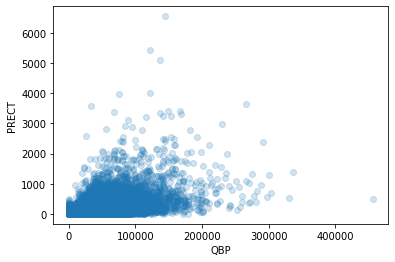

In [0]:
plt.scatter(ans.QBP, ans.Prect, alpha=0.2)
plt.xlabel('QBP')
plt.ylabel('PRECT')

In [0]:
ans

,Prect,QBP
0,9.779580e-01,4.874758e-06
1,9.958283e-01,1.859595e-05
2,9.800503e-01,2.319214e-07
3,1.028489e+00,1.138767e-08
4,9.657900e-01,1.174204e-05
...,...,...
8121851,2.801349e-09,6.182879e-02
8121852,1.929005e-14,1.168423e-01
8121853,NaN,2.215347e+00
8121854,NaN,1.595336e-01


Text(0, 0.5, 'PRECT')

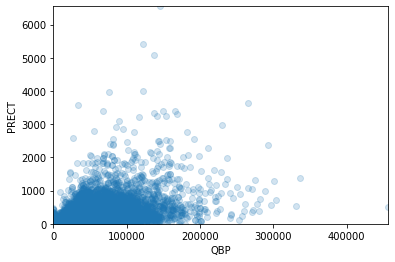

In [0]:
plt.scatter(ans.QBP, ans.Prect, alpha=0.2)
plt.xlim(ans.QBP.min(), ans.QBP.max())
plt.ylim(ans.Prect.min(), ans.Prect.max())
plt.xlabel('QBP')
plt.ylabel('PRECT')

In [0]:
results = pickle.load(open('results_diff_optim_hrishi.pkl', 'rb'))

In [0]:
p = s.inv_boxcox(results.Prect, 0.1)
q = results.QBP**4

In [0]:
t = results.TBP

In [0]:
ans = pd.concat([p.reset_index(drop=True),q.reset_index(drop=True), pd.Series(t.values)], axis=1)

In [0]:
ans.rename(columns = {0:'TBP'},inplace=True)

In [61]:
ans.head()

,Prect,QBP,TBP
0,1.374145e-07,0.002573,230.510773
1,4.603424e-07,0.002266,222.142258
2,1.200512e-09,0.019648,254.463882
3,6.923879e-09,0.003664,237.199341
4,NaN,0.055442,338.611450


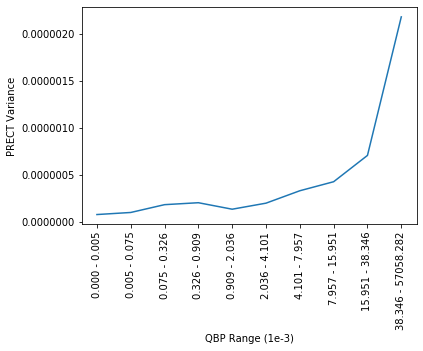

In [66]:
ans_sorted = ans.sort_values(by='QBP')
prect_vars_result = []
qbp_bins_result_str = []
for split in np.array_split(ans_sorted,10,axis = 0):
  prect_vars_result.append(np.std(split.Prect)**2)
  qbp_bins_result_str.append("{:.3f}".format(split.QBP.min()*(10**3))+" - "+"{:.3f}".format(split.QBP.max()*(10**3)))

plt.plot(prect_vars_result)
plt.xticks(list(range(0,10)),labels=qbp_bins_result_str,rotation=90)
plt.xlabel('QBP Range (1e-3)')
plt.ylabel('PRECT Variance')
plt.show()